In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import re
import numpy as np
import pandas as pd

import SequenceDataORM as sqd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///NS001_evolved_mutations_copy8.db', echo=False) # our database connection
session = sessionmaker(bind=engine)() # the session object is how we make queries through sqlalchemy

# Ignoring ancestral polymorphisms, how many SNPs surpass a given frequency threshold for each sample?

In [3]:
ancestral_snps = [snp for snp in session.query(sqd.SNP_Mutation)
                  if ('Aggregate_NS001_Ancestors' in snp.samples) or
                     ('Ancestor_S1' in snp.samples) or
                     ('Ancestor_S2' in snp.samples) or
                     ('Ancestor_S3' in snp.samples)]

In [4]:
def new_snps_above_frequency(sample, freq_cutoff):
    snps_above_frequency = [snp for snp in
                            (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                             .filter(sqd.SNP_Evidence.sample==sample)
                             .filter(sqd.SNP_Evidence.frequency >= freq_cutoff))]
    new_snps_above_freq = [snp for snp in snps_above_frequency
                           if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                              ('Ancestor_S1' not in snp.samples) and
                              ('Ancestor_S2' not in snp.samples) and
                              ('Ancestor_S3' not in snp.samples)]
    return new_snps_above_freq

In [5]:
evolvedt1_samples = [smpl for smpl in session.query(sqd.DNA_Sample).filter(sqd.DNA_Sample.name.like('%t1%'))]
evolvedt2_samples = [smpl for smpl in session.query(sqd.DNA_Sample).filter(sqd.DNA_Sample.name.like('%t2%'))]

In [6]:
def mu_and_counts(samples, cutoff):
    mus = []
    counts = []
    names = []
    for sample in samples:
        mu = (session.query(sqd.Strain, sqd.MutationCondition)
                     .filter(sqd.Strain.mutation_rate_condition==sqd.MutationCondition.name)
                     .filter(sqd.Strain.name==sample.strain)
                     .first())[1].mu_est
        count = len(new_snps_above_frequency(sample.name, cutoff))
        mus.append(mu)
        counts.append(count)
        names.append(sample.name)
    mu_c_df = pd.DataFrame(data={'name': names, 'mu': mus, 'count': counts})
    return mu_c_df
    
def plot_snps_by_condition(mu_c_df, axes, color='r'):
    for row in mu_c_df.itertuples():
        axes.plot(row.mu, row.count, '.', color=color, markersize=12);
    means = mu_c_df.groupby(by='mu').mean()
    for row in means.itertuples():
        axes.plot(row.Index, row.count, '*', color=color, markersize=20, markeredgecolor='k')
    axes.set_xscale('log')
    ax.set_xlabel('mutation rate (rif resistance)', fontsize=20);
    ax.set_ylabel('number of mutations', fontsize=20);

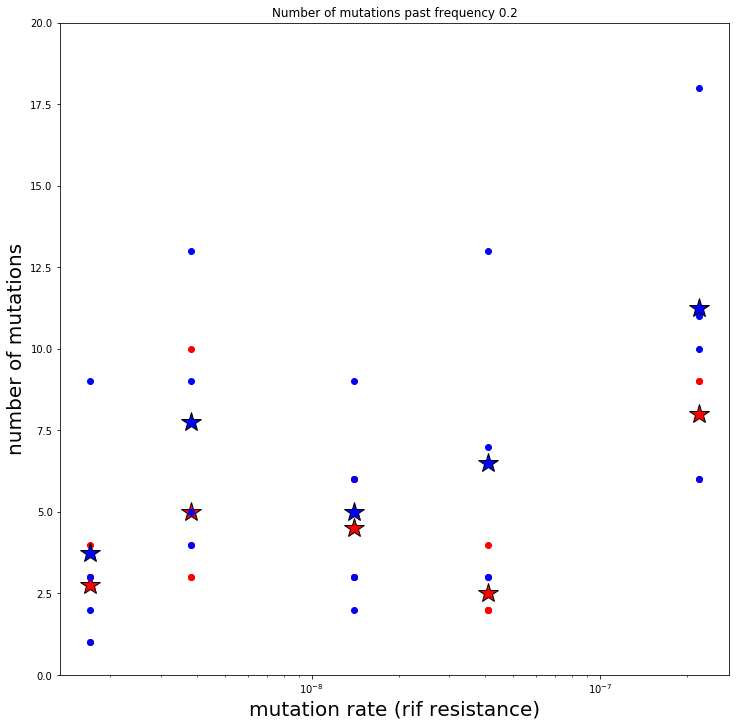

In [7]:
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
cutoff = .2
evolved_t1_df = mu_and_counts(evolvedt1_samples, cutoff)
evolved_t2_df = mu_and_counts(evolvedt2_samples, cutoff)
plot_snps_by_condition(evolved_t1_df, ax, 'r')
plot_snps_by_condition(evolved_t2_df, ax, 'b')
ax.set_title(f'Number of mutations past frequency {cutoff}');
ax.set_ylim(0,20);

In [94]:
def cumulative_mu_counts(sample):
    snps = [snp for snp in (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                                   .filter(sqd.SNP_Evidence.sample==sample)
                                   .order_by(sqd.SNP_Evidence.frequency))]
    new_snps = [snp for snp in snps if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                                       ('Ancestor_S1' not in snp.samples) and
                                       ('Ancestor_S2' not in snp.samples) and
                                       ('Ancestor_S3' not in snp.samples)]
    new_snp_evs = [(session.query(sqd.SNP_Evidence)
                           .filter(sqd.SNP_Evidence.sample==sample)
                           .filter(sqd.SNP_Evidence.chr_position==snp.chr_position)
                           .filter(sqd.SNP_Evidence.new_base==snp.new_base)
                           .first()) for snp in new_snps]
    new_snp_freqs = np.array([snp_ev.frequency for snp_ev in new_snp_evs])[::-1]
    counts = np.arange(1,len(new_snp_freqs)+1)
    return new_snp_freqs, counts

def func_cum(freqs, counts):
    def cum_dist(x):
        try:
            cl_idx = np.where(freqs>x)[0][-1]
        except IndexError:
            return 0
        return counts[cl_idx]
    return cum_dist

def mean_func(*args):
    def mmean(x):
        return np.mean([arg(x) for arg in args])
    return mmean

def median_func(*args):
    def mmedian(x):
        return np.median([arg(x) for arg in args])
    return mmedian

def min_func(*args):
    def mmin(x):
        return np.min([arg(x) for arg in args])
    return mmin

def max_func(*args):
    def mmax(x):
        return np.max([arg(x) for arg in args])
    return mmax

(1, 0.04)

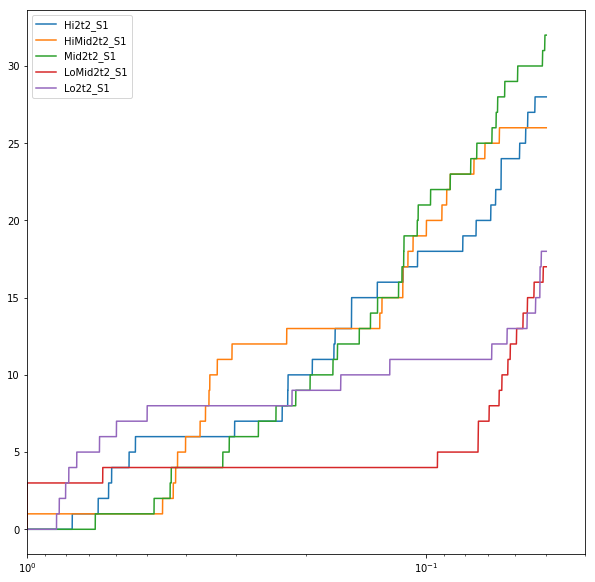

In [83]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
for smpr in evolvedt2_samples:
    if smpr.name in ['Lo2t2_S1', 'LoMid2t2_S1', 'Mid2t2_S1', 'HiMid2t2_S1', 'Hi2t2_S1']:
        fraqs, cornts = cumulative_mu_counts(smpr.name)
        cumdist = func_cum(fraqs, cornts)
        x = np.linspace(1,.05,num=10000)
        y = np.array([cumdist(i) for i in x])
        axes.semilogx(x, y, label=smpr.name)
axes.legend()
axes.set_xlim(1,.04)

(1, 0.04)

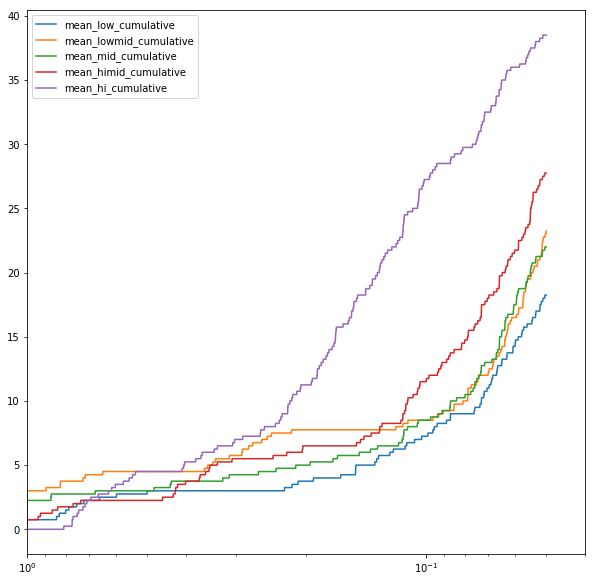

In [93]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
x = np.linspace(1,.05,num=10000)

lodists = []
for smpr in ['Lo1t2_S1', 'Lo2t2_S1', 'Lo3t2_S1', 'Lo4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lodists.append(cumdist)
mean_low = mean_func(*lodists)
y_low = np.array([mean_low(i) for i in x])
axes.semilogx(x, y_low, label='mean_low_cumulative')

lomiddists = []
for smpr in ['LoMid1t2_S1', 'LoMid2t2_S1', 'LoMid3t2_S1', 'LoMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lomiddists.append(cumdist)
mean_lowmid = mean_func(*lomiddists)
y_lowmid = np.array([mean_lowmid(i) for i in x])
axes.semilogx(x, y_lowmid, label='mean_lowmid_cumulative')

middists = []
for smpr in ['Mid1t2_S1', 'Mid2t2_S1', 'Mid3t2_S1', 'Mid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    middists.append(cumdist)
mean_mid = mean_func(*middists)
y_mid = np.array([mean_mid(i) for i in x])
axes.semilogx(x, y_mid, label='mean_mid_cumulative')

himiddists = []
for smpr in ['HiMid1t2_S1', 'HiMid2t2_S1', 'HiMid3t2_S1', 'HiMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    himiddists.append(cumdist)
mean_himid = mean_func(*himiddists)
y_himid = np.array([mean_himid(i) for i in x])
axes.semilogx(x, y_himid, label='mean_himid_cumulative')

hidists = []
for smpr in ['Hi1t2_S1', 'Hi2t2_S1', 'Hi3t2_S1', 'Hi4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    hidists.append(cumdist)
mean_hi = mean_func(*hidists)
y_hi = np.array([mean_hi(i) for i in x])
axes.semilogx(x, y_hi, label='mean_hi_cumulative')

axes.legend()
axes.set_xlim(1,.04)

(1, 0.04)

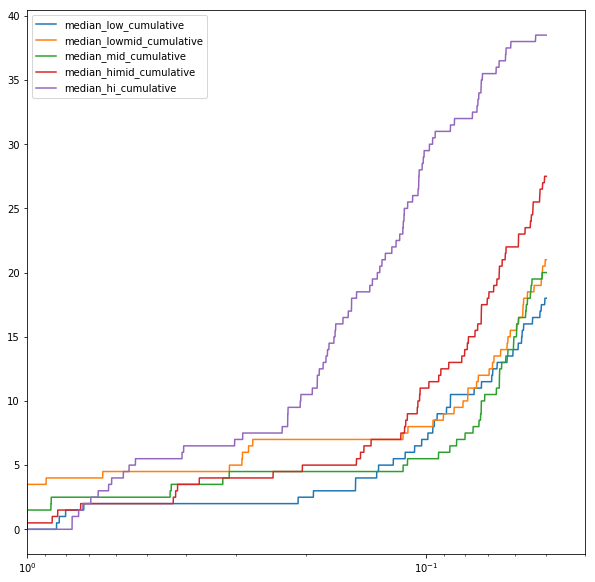

In [95]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
x = np.linspace(1,.05,num=10000)

lodists = []
for smpr in ['Lo1t2_S1', 'Lo2t2_S1', 'Lo3t2_S1', 'Lo4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lodists.append(cumdist)
mean_low = median_func(*lodists)
y_low = np.array([mean_low(i) for i in x])
axes.semilogx(x, y_low, label='median_low_cumulative')

lomiddists = []
for smpr in ['LoMid1t2_S1', 'LoMid2t2_S1', 'LoMid3t2_S1', 'LoMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lomiddists.append(cumdist)
mean_lowmid = median_func(*lomiddists)
y_lowmid = np.array([mean_lowmid(i) for i in x])
axes.semilogx(x, y_lowmid, label='median_lowmid_cumulative')

middists = []
for smpr in ['Mid1t2_S1', 'Mid2t2_S1', 'Mid3t2_S1', 'Mid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    middists.append(cumdist)
mean_mid = median_func(*middists)
y_mid = np.array([mean_mid(i) for i in x])
axes.semilogx(x, y_mid, label='median_mid_cumulative')

himiddists = []
for smpr in ['HiMid1t2_S1', 'HiMid2t2_S1', 'HiMid3t2_S1', 'HiMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    himiddists.append(cumdist)
mean_himid = median_func(*himiddists)
y_himid = np.array([mean_himid(i) for i in x])
axes.semilogx(x, y_himid, label='median_himid_cumulative')

hidists = []
for smpr in ['Hi1t2_S1', 'Hi2t2_S1', 'Hi3t2_S1', 'Hi4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    hidists.append(cumdist)
mean_hi = median_func(*hidists)
y_hi = np.array([mean_hi(i) for i in x])
axes.semilogx(x, y_hi, label='median_hi_cumulative')

axes.legend()
axes.set_xlim(1,.04)

# Comparing to immediate ancestor at time t1 instead of original ancestor

In [8]:
def new_snps_above_t1frequency(sample, freq_cutoff):
    if 't2' not in sample:
        raise ValueError('Need a sample from time t2')
    snps_above_frequency = [snp for snp in
                            (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                             .filter(sqd.SNP_Evidence.sample==sample)
                             .filter(sqd.SNP_Evidence.frequency >= freq_cutoff))]
    ancestor_sample_name = re.sub('t2', 't1', sample)
    new_snps_above_freq = [snp for snp in snps_above_frequency
                           if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                              ('Ancestor_S1' not in snp.samples) and
                              ('Ancestor_S2' not in snp.samples) and
                              ('Ancestor_S3' not in snp.samples) and
                              (ancestor_sample_name not in snp.samples)]
    return new_snps_above_freq

def mu_and_counts_reft1(samples, cutoff):
    mus = []
    counts = []
    names = []
    for sample in samples:
        mu = (session.query(sqd.Strain, sqd.MutationCondition)
                     .filter(sqd.Strain.mutation_rate_condition==sqd.MutationCondition.name)
                     .filter(sqd.Strain.name==sample.strain)
                     .first())[1].mu_est
        count = len(new_snps_above_t1frequency(sample.name, cutoff))
        mus.append(mu)
        counts.append(count)
        names.append(sample.name)
    mu_c_df = pd.DataFrame(data={'name': names, 'mu': mus, 'count': counts})
    return mu_c_df

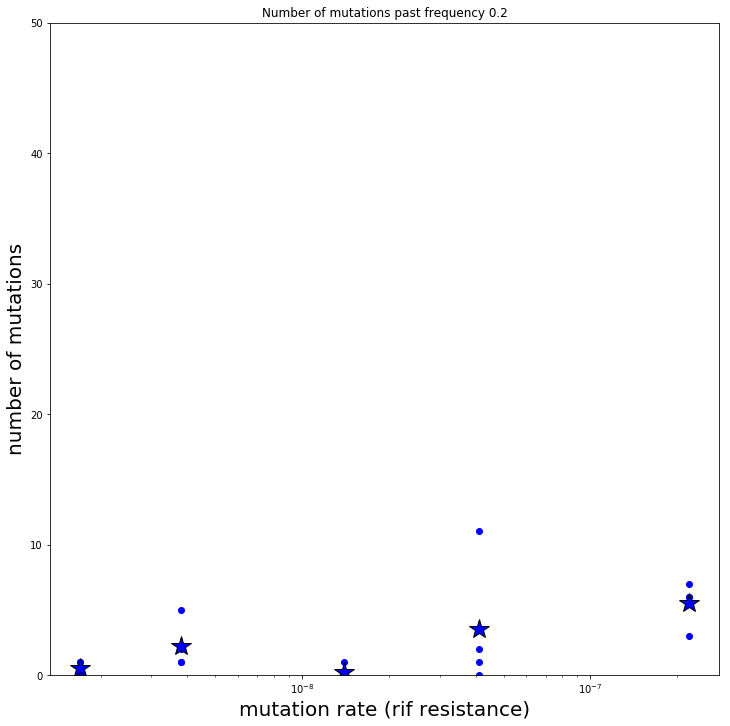

In [9]:
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
cutoff = .2
evolved_t2_df_c1 = mu_and_counts_reft1(evolvedt2_samples, cutoff)
plot_snps_by_condition(evolved_t2_df_c1, ax, 'b')
ax.set_title(f'Number of mutations past frequency {cutoff}');
ax.set_ylim(0,50);

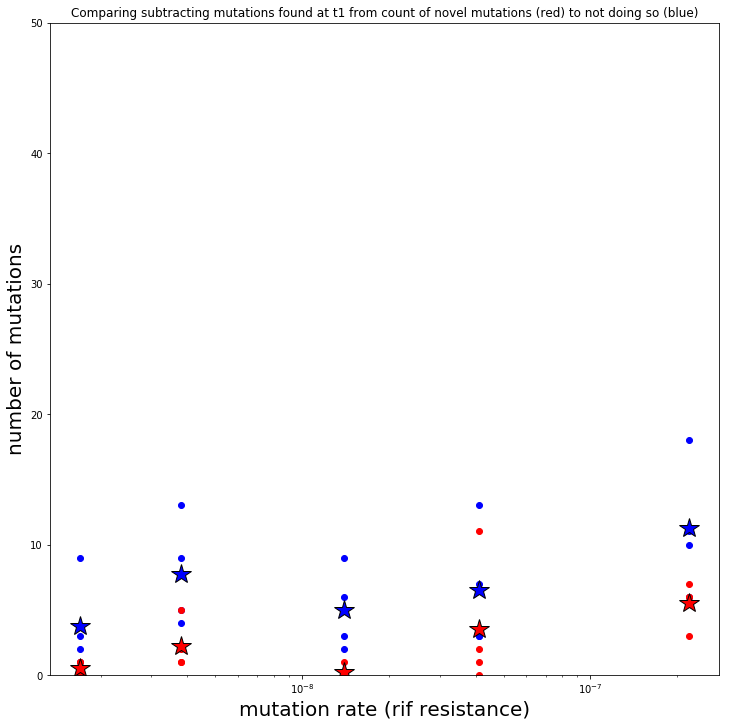

In [10]:
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
plot_snps_by_condition(evolved_t2_df, ax, 'b')
plot_snps_by_condition(evolved_t2_df_c1, ax, 'r')
ax.set_ylim(0,50);
ax.set_title('Comparing subtracting mutations found at t1 from count of novel mutations (red) to not doing so (blue)');